<a href="https://colab.research.google.com/github/zulhabibie/Data-Intelligent/blob/master/Analysis_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import the libraries
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
from keras.preprocessing.sequence import pad_sequences
import joblib
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report

In [ ]:
# Twitter API credentials
consumer_key= '57wfyVSkzCJP2WWOqeMNHGTrr'
consumer_secret= 'ANc4PRf4ggKmmfBAuo8iLv5qGRLacx0AaZZwLOria4ozMG9ZYw'
access_token= '1072640288147955712-gLBDm9lPnkUhrc3m4NEGyzu2NWaoHq'
access_token_secret= 'L7A98Mo8kfMwBVjnG8rZ8EcynpmlfRT6qRMgqZgjJslut'

In [ ]:
#create the authentication object
authenticate = tweepy.OAuthHandler(consumer_key, consumer_secret)

#set the access token access secret
authenticate.set_access_token (access_token, access_token_secret)

#Create the API object while passing in teh auth information 
api = tweepy.API(authenticate, wait_on_rate_limit = True)

In [ ]:
# hasil_search = api.search(q='vaksin', count=500, lang='en')
hasil_search = tweepy.Cursor(api.search, q='covid Jakarta -filter:retweets', tweet_mode='extended',lang="id").items(500)

In [ ]:
result = []
for tweet in hasil_search :
  tweet_properties = {}
  tweet_properties['tanggal'] = tweet.created_at
  tweet_properties['user']=tweet.user.screen_name
  tweet_properties['cuitan'] = tweet.full_text
  tweet_bersih = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\s+)"," ",tweet.full_text).split())
  analisis = TextBlob(tweet_bersih)
  try :
    analisis = analisis.translate(to="en")
  except Exception as e :
    print(e)

  tweet_properties['polarity'] = analisis.sentiment.polarity
  tweet_properties['subjectivity'] = analisis.sentiment.subjectivity

  if analisis.sentiment.polarity > 0.0 :
    tweet_properties['sentiment'] = 'Positif'
  elif analisis.sentiment.polarity == 0.0 :
    tweet_properties['sentiment'] = 'Netral'
  else :
    tweet_properties['sentiment'] = 'Negatif'


  if tweet.retweet_count > 0 :
    if tweet_properties not in result :
      result.append(tweet_properties)
  else :
    result.append(tweet_properties)

In [ ]:
result

[{'cuitan': '@evimsofian @ary_ahw 2 Maret 2020:   Corona dinyatakan positif atas 2 warga yg tertular di Jakarta. \n\nAnies pun baru membentuk Tim Tanggap Covid pada 2 Maret 2020\nhttps://t.co/yA2Y2ewZZb\n\nBandingkan dgn Pemprov Sumut yg sudah membentuk Timsus sejak  8 Februari 2020\nhttps://t.co/qLAeORWVNi https://t.co/fDYjhA3qk9',
  'polarity': 0.2636363636363636,
  'sentiment': 'Positif',
  'subjectivity': 0.7227272727272727,
  'tanggal': datetime.datetime(2021, 7, 6, 17, 13, 55),
  'user': 'DavidGosal4'},
 {'cuitan': '@evimsofian 2 Maret 2020:   Corona dinyatakan positif atas 2 warga yg tertular di Jakarta. \n\nAnies pun baru membentuk Tim Tanggap Covid pada 2 Maret 2020\nhttps://t.co/yA2Y2ewZZb\n\nBandingkan dgn Pemprov Sumut yg sudah membentuk Timsus sejak  8 Februari 2020\nhttps://t.co/qLAeORWVNi',
  'polarity': 0.22727272727272727,
  'sentiment': 'Positif',
  'subjectivity': 0.5454545454545454,
  'tanggal': datetime.datetime(2021, 7, 6, 17, 11, 19),
  'user': 'DavidGosal4'},
 {

In [ ]:
df = pd.DataFrame(result)

In [ ]:
df

,tanggal,user,cuitan,polarity,subjectivity,sentiment
0,2021-07-06 17:13:55,DavidGosal4,@evimsofian @ary_ahw 2 Maret 2020: Corona di...,0.263636,0.722727,Positif
1,2021-07-06 17:11:19,DavidGosal4,@evimsofian 2 Maret 2020: Corona dinyatakan ...,0.227273,0.545455,Positif
2,2021-07-06 17:10:34,dancersejati1,• Gatot melihat lonjakan kasus Covid-19 dalam ...,0.081061,0.350758,Positif
3,2021-07-06 17:07:59,raymon_viky,@msaid_didu Mau tanya dong...yg positif 30rbu ...,0.363636,0.522727,Positif
4,2021-07-06 16:52:07,OdiikkShiba,@NegeriDagelanz Itu waktu pertama kali covid d...,0.160000,0.561667,Positif
...,...,...,...,...,...,...
495,2021-07-06 06:33:54,bfndrk,Susu beruang buat pasien Covid-19 cuma akal-ak...,0.000000,0.000000,Netral
496,2021-07-06 06:33:00,ksr_upnvj,[ URGENT ]\n\nDibutuhkan segera pendonor bergo...,0.500000,0.500000,Positif
497,2021-07-06 06:31:24,Radar_Cirebon,JAKARTA – Dr Faheem Younus asal Amerika Serika...,0.000000,0.375000,Netral
498,2021-07-06 06:31:17,lagiviralcoy,Mulai besok pemerintah merilis telemedicine di...,0.000000,0.100000,Netral


In [ ]:
def cleaning_text(text) :
    text = re.sub(r'[^0-9A-Za-z \t]',r'' ,text) 
    text = re.sub(r'\b\w(1,2)\b',r'',text)
    text = re.sub(r'#','', text)
    text = re.sub(r'[@]',r' ',text)
    text = re.sub(r'\s\s+',r'',text)
    text = re.sub(r'\n',r'',text)
    return text

df['CleanTweet'] = df['cuitan'].apply(lambda x: cleaning_text(x))
df.head()

,tanggal,user,cuitan,polarity,subjectivity,sentiment,CleanTweet
0,2021-07-06 17:13:55,DavidGosal4,@evimsofian @ary_ahw 2 Maret 2020: Corona di...,0.263636,0.722727,Positif,evimsofian aryahw 2 Maret 2020Corona dinyataka...
1,2021-07-06 17:11:19,DavidGosal4,@evimsofian 2 Maret 2020: Corona dinyatakan ...,0.227273,0.545455,Positif,evimsofian 2 Maret 2020Corona dinyatakan posit...
2,2021-07-06 17:10:34,dancersejati1,• Gatot melihat lonjakan kasus Covid-19 dalam ...,0.081061,0.350758,Positif,Gatot melihat lonjakan kasus Covid19 dalam se...
3,2021-07-06 17:07:59,raymon_viky,@msaid_didu Mau tanya dong...yg positif 30rbu ...,0.363636,0.522727,Positif,msaiddidu Mau tanya dongyg positif 30rbu itu d...
4,2021-07-06 16:52:07,OdiikkShiba,@NegeriDagelanz Itu waktu pertama kali covid d...,0.160000,0.561667,Positif,NegeriDagelanz Itu waktu pertama kali covid da...


In [ ]:
# tokenisasi 
def tokennization(text):
    text = re.split ('\W+', text)
    return text

df['Tokennization'] = df['CleanTweet'].apply(lambda x: tokennization(x.lower()))
df.head()

,tanggal,user,cuitan,polarity,subjectivity,sentiment,CleanTweet,Tokennization
0,2021-07-06 17:13:55,DavidGosal4,@evimsofian @ary_ahw 2 Maret 2020: Corona di...,0.263636,0.722727,Positif,evimsofian aryahw 2 Maret 2020Corona dinyataka...,"[evimsofian, aryahw, 2, maret, 2020corona, din..."
1,2021-07-06 17:11:19,DavidGosal4,@evimsofian 2 Maret 2020: Corona dinyatakan ...,0.227273,0.545455,Positif,evimsofian 2 Maret 2020Corona dinyatakan posit...,"[evimsofian, 2, maret, 2020corona, dinyatakan,..."
2,2021-07-06 17:10:34,dancersejati1,• Gatot melihat lonjakan kasus Covid-19 dalam ...,0.081061,0.350758,Positif,Gatot melihat lonjakan kasus Covid19 dalam se...,"[, gatot, melihat, lonjakan, kasus, covid19, d..."
3,2021-07-06 17:07:59,raymon_viky,@msaid_didu Mau tanya dong...yg positif 30rbu ...,0.363636,0.522727,Positif,msaiddidu Mau tanya dongyg positif 30rbu itu d...,"[msaiddidu, mau, tanya, dongyg, positif, 30rbu..."
4,2021-07-06 16:52:07,OdiikkShiba,@NegeriDagelanz Itu waktu pertama kali covid d...,0.160000,0.561667,Positif,NegeriDagelanz Itu waktu pertama kali covid da...,"[negeridagelanz, itu, waktu, pertama, kali, co..."


In [ ]:
pip install nltk

In [ ]:
# menghapus stopwords dan simpan pada stop_removal
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('indonesian')

def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

df['Stop_removal'] = df['Tokennization'].apply(lambda x: remove_stopwords(x))

df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,tanggal,user,cuitan,polarity,subjectivity,sentiment,CleanTweet,Tokennization,Stop_removal
0,2021-07-06 17:13:55,DavidGosal4,@evimsofian @ary_ahw 2 Maret 2020: Corona di...,0.263636,0.722727,Positif,evimsofian aryahw 2 Maret 2020Corona dinyataka...,"[evimsofian, aryahw, 2, maret, 2020corona, din...","[evimsofian, aryahw, 2, maret, 2020corona, din..."
1,2021-07-06 17:11:19,DavidGosal4,@evimsofian 2 Maret 2020: Corona dinyatakan ...,0.227273,0.545455,Positif,evimsofian 2 Maret 2020Corona dinyatakan posit...,"[evimsofian, 2, maret, 2020corona, dinyatakan,...","[evimsofian, 2, maret, 2020corona, dinyatakan,..."
2,2021-07-06 17:10:34,dancersejati1,• Gatot melihat lonjakan kasus Covid-19 dalam ...,0.081061,0.350758,Positif,Gatot melihat lonjakan kasus Covid19 dalam se...,"[, gatot, melihat, lonjakan, kasus, covid19, d...","[, gatot, lonjakan, covid19, sebulan, temuan, ..."
3,2021-07-06 17:07:59,raymon_viky,@msaid_didu Mau tanya dong...yg positif 30rbu ...,0.363636,0.522727,Positif,msaiddidu Mau tanya dongyg positif 30rbu itu d...,"[msaiddidu, mau, tanya, dongyg, positif, 30rbu...","[msaiddidu, dongyg, positif, 30rbu, sluruh, in..."
4,2021-07-06 16:52:07,OdiikkShiba,@NegeriDagelanz Itu waktu pertama kali covid d...,0.160000,0.561667,Positif,NegeriDagelanz Itu waktu pertama kali covid da...,"[negeridagelanz, itu, waktu, pertama, kali, co...","[negeridagelanz, kali, covid, pemimpin, menena..."


In [ ]:
tweet_positif = [t for t in result if t['sentiment'] == 'Positif']
tweet_netral = [t for t in result if t['sentiment'] == 'Netral']
tweet_negatif = [t for t in result if t['sentiment'] == 'Negatif']

In [ ]:
print('Hasil Sentiment')
print("Positif : ", len(tweet_positif))
print("Netral : ", len(tweet_netral))
print("Negatif : ", len(tweet_negatif))


Hasil Sentiment
Positif :  214
Netral :  213
Negatif :  73


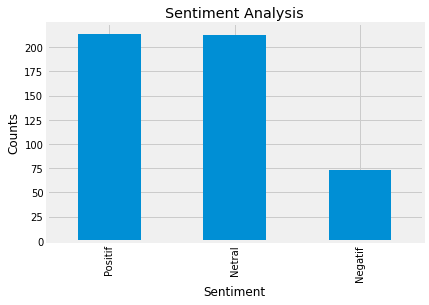

In [ ]:
df['sentiment'].value_counts()
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['sentiment'].value_counts().plot(kind='bar')

Text(0, 0.5, 'subjectivity')

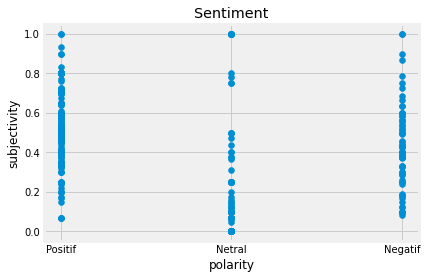

In [ ]:
#write your Scatter Plot Matplotlib here
fig,ax = plt.subplots()
ax.scatter(df['sentiment'], df['subjectivity'])
ax.set_title('Sentiment')
ax.set_xlabel('polarity')
ax.set_ylabel('subjectivity')

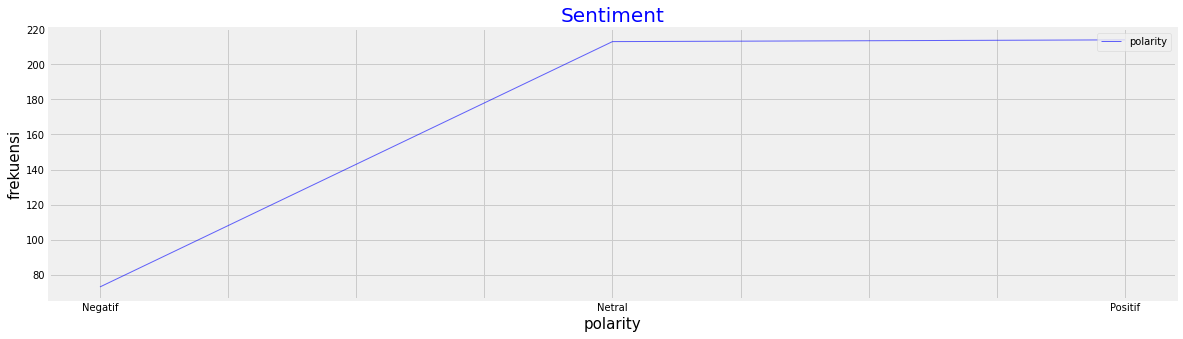

In [ ]:
df['sentiment'].value_counts().sort_index().plot(kind = 'line',color = 'b',label = 'polarity',linewidth=1, alpha = 0.6,grid = True,linestyle = '-',figsize=(18,5))
plt.legend(loc='upper right')   
plt.xlabel('polarity',fontsize = 15,color='black')             
plt.ylabel('frekuensi',fontsize = 15,color='black')
plt.title('Sentiment',fontsize = 20,color='blue')            
plt.show()


In [ ]:
df = df[['CleanTweet', 'polarity', 'subjectivity']]
df

,CleanTweet,polarity,subjectivity
0,evimsofian aryahw 2 Maret 2020Corona dinyataka...,0.263636,0.722727
1,evimsofian 2 Maret 2020Corona dinyatakan posit...,0.227273,0.545455
2,Gatot melihat lonjakan kasus Covid19 dalam se...,0.081061,0.350758
3,msaiddidu Mau tanya dongyg positif 30rbu itu d...,0.363636,0.522727
4,NegeriDagelanz Itu waktu pertama kali covid da...,0.160000,0.561667
...,...,...,...
495,Susu beruang buat pasien Covid19 cuma akalakal...,0.000000,0.000000
496,URGENT Dibutuhkan segera pendonor bergolongan...,0.500000,0.500000
497,JAKARTADr Faheem Younus asal Amerika Serikat A...,0.000000,0.375000
498,Mulai besok pemerintah merilis telemedicine di...,0.000000,0.100000


In [ ]:
Analysis = df['CleanTweet']
try:
  Analysis = str ( Analysis.get('Analysis', '' ) ) 
except Exception as e:
  print (e)

def getAnalysis(score) :
  if score < 0 :
    return -1
  elif score == 0 :
    return 0
  else : 
    return 1

df['Analysis'] = df['polarity'].apply(getAnalysis)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [ ]:
df.head()

,CleanTweet,polarity,subjectivity,Analysis
0,evimsofian aryahw 2 Maret 2020Corona dinyataka...,0.263636,0.722727,1
1,evimsofian 2 Maret 2020Corona dinyatakan posit...,0.227273,0.545455,1
2,Gatot melihat lonjakan kasus Covid19 dalam se...,0.081061,0.350758,1
3,msaiddidu Mau tanya dongyg positif 30rbu itu d...,0.363636,0.522727,1
4,NegeriDagelanz Itu waktu pertama kali covid da...,0.160000,0.561667,1


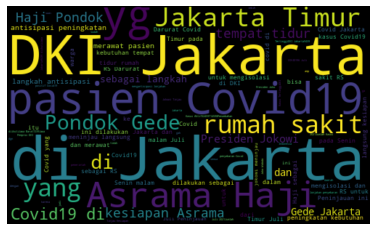

In [ ]:
# wordCloud
allWords = ' '.join( [twts for twts in df['CleanTweet']] )
wordCloud = WordCloud(width = 500, height = 300, random_state= 21, max_font_size=119).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [ ]:
# ------ Case Folding --------
# gunakan fungsi Series.str.lower() pada Pandas
df['CleanTweet'] = df['CleanTweet'].str.lower()


df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,CleanTweet,polarity,subjectivity,Analysis
0,evimsofian aryahw 2 maret 2020corona dinyataka...,0.263636,0.722727,1
1,evimsofian 2 maret 2020corona dinyatakan posit...,0.227273,0.545455,1
2,gatot melihat lonjakan kasus covid19 dalam se...,0.081061,0.350758,1
3,msaiddidu mau tanya dongyg positif 30rbu itu d...,0.363636,0.522727,1
4,negeridagelanz itu waktu pertama kali covid da...,0.160000,0.561667,1
...,...,...,...,...
495,susu beruang buat pasien covid19 cuma akalakal...,0.000000,0.000000,0
496,urgent dibutuhkan segera pendonor bergolongan...,0.500000,0.500000,1
497,jakartadr faheem younus asal amerika serikat a...,0.000000,0.375000,0
498,mulai besok pemerintah merilis telemedicine di...,0.000000,0.100000,0


In [ ]:
import string 
import re #regex library

# import word_tokenize & FreqDist from NLTK
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist

# ------ Tokenizing ---------

def remove_links(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")
                
df['CleanTweet'] = df['CleanTweet'].apply(remove_links)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#remove number
def remove_number(text):
    return  re.sub(r"\d+", " ", text)

df['CleanTweet'] = df['CleanTweet'].apply(remove_number)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

df['CleanTweet'] = df['CleanTweet'].apply(remove_punctuation)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", " ", text)

df['CleanTweet'] = df['CleanTweet'].apply(remove_singl_char)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# NLTK word tokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)

df['Tokenize'] = df['CleanTweet'].apply(word_tokenize_wrapper)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
df

,CleanTweet,polarity,subjectivity,Analysis,Tokenize
0,evimsofian aryahw maret corona dinyatakan p...,0.263636,0.722727,1,"[evimsofian, aryahw, maret, corona, dinyatakan..."
1,evimsofian maret corona dinyatakan positif ...,0.227273,0.545455,1,"[evimsofian, maret, corona, dinyatakan, positi..."
2,gatot melihat lonjakan kasus covid dalam sebu...,0.081061,0.350758,1,"[gatot, melihat, lonjakan, kasus, covid, dalam..."
3,msaiddidu mau tanya dongyg positif rbu itu da...,0.363636,0.522727,1,"[msaiddidu, mau, tanya, dongyg, positif, rbu, ..."
4,negeridagelanz itu waktu pertama kali covid da...,0.160000,0.561667,1,"[negeridagelanz, itu, waktu, pertama, kali, co..."
...,...,...,...,...,...
495,susu beruang buat pasien covid cuma akalakala...,0.000000,0.000000,0,"[susu, beruang, buat, pasien, covid, cuma, aka..."
496,urgent dibutuhkan segera pendonor bergolongan ...,0.500000,0.500000,1,"[urgent, dibutuhkan, segera, pendonor, bergolo..."
497,jakartadr faheem younus asal amerika serikat a...,0.000000,0.375000,0,"[jakartadr, faheem, younus, asal, amerika, ser..."
498,mulai besok pemerintah merilis telemedicine di...,0.000000,0.100000,0,"[mulai, besok, pemerintah, merilis, telemedici..."


In [ ]:
# NLTK calc frequency distribution
def freqDist_wrapper(text):
    return FreqDist(text)

Ulasan_fqsist = df['Tokenize'].apply(freqDist_wrapper)

print('Frequency Tokens : \n') 
print(Ulasan_fqsist.head().apply(lambda x : x.most_common()))

Frequency Tokens : 

0    [(maret, 2), (yg, 2), (membentuk, 2), (evimsof...
1    [(maret, 2), (yg, 2), (membentuk, 2), (evimsof...
2    [(gatot, 1), (melihat, 1), (lonjakan, 1), (kas...
3    [(mau, 2), (itu, 2), (dari, 2), (mna, 2), (yg,...
4    [(itu, 2), (waktu, 2), (apa, 2), (negeridagela...
Name: Tokenize, dtype: object


In [ ]:
from nltk.corpus import stopwords

In [ ]:
list_stopwords = stopwords.words('indonesian')

In [ ]:
#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

df['stop_removed'] = df['Tokenize'].apply(stopwords_removal) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
df

,CleanTweet,polarity,subjectivity,Analysis,Tokenize,stop_removed
0,evimsofian aryahw maret corona dinyatakan p...,0.263636,0.722727,1,"[evimsofian, aryahw, maret, corona, dinyatakan...","[evimsofian, aryahw, maret, corona, dinyatakan..."
1,evimsofian maret corona dinyatakan positif ...,0.227273,0.545455,1,"[evimsofian, maret, corona, dinyatakan, positi...","[evimsofian, maret, corona, dinyatakan, positi..."
2,gatot melihat lonjakan kasus covid dalam sebu...,0.081061,0.350758,1,"[gatot, melihat, lonjakan, kasus, covid, dalam...","[gatot, lonjakan, covid, sebulan, temuan, jeni..."
3,msaiddidu mau tanya dongyg positif rbu itu da...,0.363636,0.522727,1,"[msaiddidu, mau, tanya, dongyg, positif, rbu, ...","[msaiddidu, dongyg, positif, rbu, sluruh, indo..."
4,negeridagelanz itu waktu pertama kali covid da...,0.160000,0.561667,1,"[negeridagelanz, itu, waktu, pertama, kali, co...","[negeridagelanz, kali, covid, pemimpin, menena..."
...,...,...,...,...,...,...
495,susu beruang buat pasien covid cuma akalakala...,0.000000,0.000000,0,"[susu, beruang, buat, pasien, covid, cuma, aka...","[susu, beruang, pasien, covid, akalakalan, ora..."
496,urgent dibutuhkan segera pendonor bergolongan ...,0.500000,0.500000,1,"[urgent, dibutuhkan, segera, pendonor, bergolo...","[urgent, dibutuhkan, pendonor, bergolongan, da..."
497,jakartadr faheem younus asal amerika serikat a...,0.000000,0.375000,0,"[jakartadr, faheem, younus, asal, amerika, ser...","[jakartadr, faheem, younus, amerika, serikat, ..."
498,mulai besok pemerintah merilis telemedicine di...,0.000000,0.100000,0,"[mulai, besok, pemerintah, merilis, telemedici...","[besok, pemerintah, merilis, telemedicine, dki..."


In [ ]:
pip install Sastrawi

     |████████████████████████████████| 215kB 5.1MB/s 


In [ ]:
pip install swifter

     |████████████████████████████████| 296kB 7.3MB/s 
     |████████████████████████████████| 122kB 37.0MB/s 
  Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
# import Sastrawi package
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter


# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df['stop_removed']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
    
print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df['Ulasan_Stemmed'] = df['stop_removed'].swifter.apply(get_stemmed_term)

3105
------------------------
evimsofian : evimsofian
aryahw : aryahw
maret : maret
corona : corona
dinyatakan : nyata
positif : positif
warga : warga
yg : yg
tertular : tular
jakarta : jakarta
anies : anies
membentuk : bentuk
tim : tim
tanggap : tanggap
covid : covid
httpstcoya : httpstcoya
ewzzbbandingkan : ewzzbbandingkan
dgn : dgn
pemprov : pemprov
sumut : sumut
timsus : timsus
februari : februari
httpstcoqlaeorwvni : httpstcoqlaeorwvni
httpstcofdyjha : httpstcofdyjha
qk : qk
gatot : gatot
lonjakan : lonjak
sebulan : bulan
temuan : temu
jenis : jenis
varian : varian
berkembang : kembang
luas : luas
kota : kota
surabaya : surabaya
medanbapakpresidenmenyerahlah : medanbapakpresidenmenyerahlah
bapakpresidenmenyerahlah : bapakpresidenmenyerahlah
msaiddidu : msaiddidu
dongyg : dongyg
rbu : rbu
sluruh : sluruh
indonesia : indonesia
doangdan : doangdan
mntak : mntak
datanya : data
mna : mna
aja : aja
covidbiar : covidbiar
percayadan : percayadan
meninggl : meninggl
sekian : sekian
ratus :

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df

,CleanTweet,polarity,subjectivity,Analysis,Tokenize,stop_removed,Ulasan_Stemmed
0,evimsofian aryahw maret corona dinyatakan p...,0.263636,0.722727,1,"[evimsofian, aryahw, maret, corona, dinyatakan...","[evimsofian, aryahw, maret, corona, dinyatakan...","[evimsofian, aryahw, maret, corona, nyata, pos..."
1,evimsofian maret corona dinyatakan positif ...,0.227273,0.545455,1,"[evimsofian, maret, corona, dinyatakan, positi...","[evimsofian, maret, corona, dinyatakan, positi...","[evimsofian, maret, corona, nyata, positif, wa..."
2,gatot melihat lonjakan kasus covid dalam sebu...,0.081061,0.350758,1,"[gatot, melihat, lonjakan, kasus, covid, dalam...","[gatot, lonjakan, covid, sebulan, temuan, jeni...","[gatot, lonjak, covid, bulan, temu, jenis, var..."
3,msaiddidu mau tanya dongyg positif rbu itu da...,0.363636,0.522727,1,"[msaiddidu, mau, tanya, dongyg, positif, rbu, ...","[msaiddidu, dongyg, positif, rbu, sluruh, indo...","[msaiddidu, dongyg, positif, rbu, sluruh, indo..."
4,negeridagelanz itu waktu pertama kali covid da...,0.160000,0.561667,1,"[negeridagelanz, itu, waktu, pertama, kali, co...","[negeridagelanz, kali, covid, pemimpin, menena...","[negeridagelanz, kali, covid, pimpin, tenang, ..."
...,...,...,...,...,...,...,...
495,susu beruang buat pasien covid cuma akalakala...,0.000000,0.000000,0,"[susu, beruang, buat, pasien, covid, cuma, aka...","[susu, beruang, pasien, covid, akalakalan, ora...","[susu, beruang, pasien, covid, akalakalan, ora..."
496,urgent dibutuhkan segera pendonor bergolongan ...,0.500000,0.500000,1,"[urgent, dibutuhkan, segera, pendonor, bergolo...","[urgent, dibutuhkan, pendonor, bergolongan, da...","[urgent, butuh, donor, golong, darah, papar, c..."
497,jakartadr faheem younus asal amerika serikat a...,0.000000,0.375000,0,"[jakartadr, faheem, younus, asal, amerika, ser...","[jakartadr, faheem, younus, amerika, serikat, ...","[jakartadr, faheem, younus, amerika, serikat, ..."
498,mulai besok pemerintah merilis telemedicine di...,0.000000,0.100000,0,"[mulai, besok, pemerintah, merilis, telemedici...","[besok, pemerintah, merilis, telemedicine, dki...","[besok, perintah, rilis, telemedicine, dki, ja..."


In [ ]:
df["Clean"] = [' '.join(map(str, l)) for l in df['Ulasan_Stemmed']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df

,CleanTweet,polarity,subjectivity,Analysis,Tokenize,stop_removed,Ulasan_Stemmed,Clean
0,evimsofian aryahw maret corona dinyatakan p...,0.263636,0.722727,1,"[evimsofian, aryahw, maret, corona, dinyatakan...","[evimsofian, aryahw, maret, corona, dinyatakan...","[evimsofian, aryahw, maret, corona, nyata, pos...",evimsofian aryahw maret corona nyata positif w...
1,evimsofian maret corona dinyatakan positif ...,0.227273,0.545455,1,"[evimsofian, maret, corona, dinyatakan, positi...","[evimsofian, maret, corona, dinyatakan, positi...","[evimsofian, maret, corona, nyata, positif, wa...",evimsofian maret corona nyata positif warga yg...
2,gatot melihat lonjakan kasus covid dalam sebu...,0.081061,0.350758,1,"[gatot, melihat, lonjakan, kasus, covid, dalam...","[gatot, lonjakan, covid, sebulan, temuan, jeni...","[gatot, lonjak, covid, bulan, temu, jenis, var...",gatot lonjak covid bulan temu jenis varian kem...
3,msaiddidu mau tanya dongyg positif rbu itu da...,0.363636,0.522727,1,"[msaiddidu, mau, tanya, dongyg, positif, rbu, ...","[msaiddidu, dongyg, positif, rbu, sluruh, indo...","[msaiddidu, dongyg, positif, rbu, sluruh, indo...",msaiddidu dongyg positif rbu sluruh indonesia ...
4,negeridagelanz itu waktu pertama kali covid da...,0.160000,0.561667,1,"[negeridagelanz, itu, waktu, pertama, kali, co...","[negeridagelanz, kali, covid, pemimpin, menena...","[negeridagelanz, kali, covid, pimpin, tenang, ...",negeridagelanz kali covid pimpin tenang warga ...
...,...,...,...,...,...,...,...,...
495,susu beruang buat pasien covid cuma akalakala...,0.000000,0.000000,0,"[susu, beruang, buat, pasien, covid, cuma, aka...","[susu, beruang, pasien, covid, akalakalan, ora...","[susu, beruang, pasien, covid, akalakalan, ora...",susu beruang pasien covid akalakalan orang jak...
496,urgent dibutuhkan segera pendonor bergolongan ...,0.500000,0.500000,1,"[urgent, dibutuhkan, segera, pendonor, bergolo...","[urgent, dibutuhkan, pendonor, bergolongan, da...","[urgent, butuh, donor, golong, darah, papar, c...",urgent butuh donor golong darah papar covid in...
497,jakartadr faheem younus asal amerika serikat a...,0.000000,0.375000,0,"[jakartadr, faheem, younus, asal, amerika, ser...","[jakartadr, faheem, younus, amerika, serikat, ...","[jakartadr, faheem, younus, amerika, serikat, ...",jakartadr faheem younus amerika serikat as dad...
498,mulai besok pemerintah merilis telemedicine di...,0.000000,0.100000,0,"[mulai, besok, pemerintah, merilis, telemedici...","[besok, pemerintah, merilis, telemedicine, dki...","[besok, perintah, rilis, telemedicine, dki, ja...",besok perintah rilis telemedicine dki jakarta ...


In [ ]:
Tweet = ' '.join(str(v) for v in df['Clean'])

In [ ]:
tokenize_tweet = word_tokenize(Tweet)

In [ ]:
tokenize_tweet

['evimsofian',
 'aryahw',
 'maret',
 'corona',
 'nyata',
 'positif',
 'warga',
 'yg',
 'tular',
 'jakarta',
 'anies',
 'bentuk',
 'tim',
 'tanggap',
 'covid',
 'maret',
 'httpstcoya',
 'ewzzbbandingkan',
 'dgn',
 'pemprov',
 'sumut',
 'yg',
 'bentuk',
 'timsus',
 'februari',
 'httpstcoqlaeorwvni',
 'httpstcofdyjha',
 'qk',
 'evimsofian',
 'maret',
 'corona',
 'nyata',
 'positif',
 'warga',
 'yg',
 'tular',
 'jakarta',
 'anies',
 'bentuk',
 'tim',
 'tanggap',
 'covid',
 'maret',
 'httpstcoya',
 'ewzzbbandingkan',
 'dgn',
 'pemprov',
 'sumut',
 'yg',
 'bentuk',
 'timsus',
 'februari',
 'httpstcoqlaeorwvni',
 'gatot',
 'lonjak',
 'covid',
 'bulan',
 'temu',
 'jenis',
 'varian',
 'kembang',
 'luas',
 'kota',
 'jakarta',
 'surabaya',
 'medanbapakpresidenmenyerahlah',
 'bapakpresidenmenyerahlah',
 'msaiddidu',
 'dongyg',
 'positif',
 'rbu',
 'sluruh',
 'indonesia',
 'jakarta',
 'doangdan',
 'mntak',
 'data',
 'mna',
 'aja',
 'yg',
 'mna',
 'covidbiar',
 'percayadan',
 'yg',
 'meninggl',
 'se

In [ ]:
fqdist = FreqDist(tokenize_tweet)
fqdist 

FreqDist({'evimsofian': 2,
          'aryahw': 1,
          'maret': 4,
          'corona': 5,
          'nyata': 2,
          'positif': 31,
          'warga': 41,
          'yg': 76,
          'tular': 17,
          'jakarta': 453,
          'anies': 27,
          'bentuk': 7,
          'tim': 8,
          'tanggap': 3,
          'covid': 520,
          'httpstcoya': 2,
          'ewzzbbandingkan': 2,
          'dgn': 19,
          'pemprov': 21,
          'sumut': 2,
          'timsus': 2,
          'februari': 2,
          'httpstcoqlaeorwvni': 2,
          'httpstcofdyjha': 1,
          'qk': 1,
          'gatot': 1,
          'lonjak': 42,
          'bulan': 1,
          'temu': 8,
          'jenis': 1,
          'varian': 17,
          'kembang': 3,
          'luas': 2,
          'kota': 30,
          'surabaya': 1,
          'medanbapakpresidenmenyerahlah': 1,
          'bapakpresidenmenyerahlah': 1,
          'msaiddidu': 2,
          'dongyg': 1,
          'rbu': 1,
         

In [ ]:
df

,CleanTweet,polarity,subjectivity,Analysis,Tokenize,stop_removed,Ulasan_Stemmed,Clean
0,evimsofian aryahw maret corona dinyatakan p...,0.263636,0.722727,1,"[evimsofian, aryahw, maret, corona, dinyatakan...","[evimsofian, aryahw, maret, corona, dinyatakan...","[evimsofian, aryahw, maret, corona, nyata, pos...",evimsofian aryahw maret corona nyata positif w...
1,evimsofian maret corona dinyatakan positif ...,0.227273,0.545455,1,"[evimsofian, maret, corona, dinyatakan, positi...","[evimsofian, maret, corona, dinyatakan, positi...","[evimsofian, maret, corona, nyata, positif, wa...",evimsofian maret corona nyata positif warga yg...
2,gatot melihat lonjakan kasus covid dalam sebu...,0.081061,0.350758,1,"[gatot, melihat, lonjakan, kasus, covid, dalam...","[gatot, lonjakan, covid, sebulan, temuan, jeni...","[gatot, lonjak, covid, bulan, temu, jenis, var...",gatot lonjak covid bulan temu jenis varian kem...
3,msaiddidu mau tanya dongyg positif rbu itu da...,0.363636,0.522727,1,"[msaiddidu, mau, tanya, dongyg, positif, rbu, ...","[msaiddidu, dongyg, positif, rbu, sluruh, indo...","[msaiddidu, dongyg, positif, rbu, sluruh, indo...",msaiddidu dongyg positif rbu sluruh indonesia ...
4,negeridagelanz itu waktu pertama kali covid da...,0.160000,0.561667,1,"[negeridagelanz, itu, waktu, pertama, kali, co...","[negeridagelanz, kali, covid, pemimpin, menena...","[negeridagelanz, kali, covid, pimpin, tenang, ...",negeridagelanz kali covid pimpin tenang warga ...
...,...,...,...,...,...,...,...,...
495,susu beruang buat pasien covid cuma akalakala...,0.000000,0.000000,0,"[susu, beruang, buat, pasien, covid, cuma, aka...","[susu, beruang, pasien, covid, akalakalan, ora...","[susu, beruang, pasien, covid, akalakalan, ora...",susu beruang pasien covid akalakalan orang jak...
496,urgent dibutuhkan segera pendonor bergolongan ...,0.500000,0.500000,1,"[urgent, dibutuhkan, segera, pendonor, bergolo...","[urgent, dibutuhkan, pendonor, bergolongan, da...","[urgent, butuh, donor, golong, darah, papar, c...",urgent butuh donor golong darah papar covid in...
497,jakartadr faheem younus asal amerika serikat a...,0.000000,0.375000,0,"[jakartadr, faheem, younus, asal, amerika, ser...","[jakartadr, faheem, younus, amerika, serikat, ...","[jakartadr, faheem, younus, amerika, serikat, ...",jakartadr faheem younus amerika serikat as dad...
498,mulai besok pemerintah merilis telemedicine di...,0.000000,0.100000,0,"[mulai, besok, pemerintah, merilis, telemedici...","[besok, pemerintah, merilis, telemedicine, dki...","[besok, perintah, rilis, telemedicine, dki, ja...",besok perintah rilis telemedicine dki jakarta ...


In [ ]:
df["Analysis"].value_counts()

 1    214
 0    213
-1     73
Name: Analysis, dtype: int64

In [ ]:
data_label = df[["Clean", "Analysis"]]

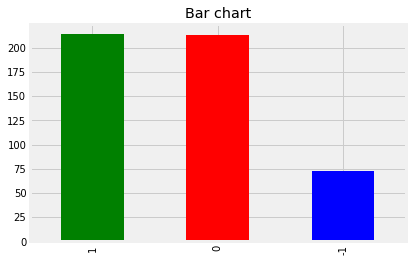

In [ ]:
sentimen_data=pd.value_counts(data_label["Analysis"], sort= True)
sentimen_data.plot(kind= 'bar', color= ["green", "red",'blue'])
plt.title('Bar chart')
plt.show()

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(decode_error='replace', encoding='utf-8')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_label['Clean'], data_label['Analysis'], 
                                                    test_size=0.2, stratify=df['Analysis'], random_state=155)

In [ ]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(400, 2352)
(100, 2352)


In [ ]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#deklarasi metode cross validation
cv_method = RepeatedStratifiedKFold(n_splits=6,  n_repeats=3, random_state=999)
#tuning hyperparameter menggunakan gridsearch

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gscv_nb = GridSearchCV(estimator=nb, 
                 param_grid=params_NB, 
                 cv=cv_method,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 

#Fitting ke Model
gscv_nb.fit(X_train,y_train)
#mendapatkan hyperparameters terbaik
gscv_nb.best_params_

Fitting 18 folds for each of 100 candidates, totalling 1800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:   29.5s finished


{'var_smoothing': 0.004328761281083057}

In [ ]:
nb = GaussianNB(var_smoothing=1.0)

In [ ]:
nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1.0)

In [ ]:
y_pred_nb = nb.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
print('--------------------- classification report  ----------------------------')
print(classification_report(y_test, y_pred_nb))

--------------------- classification report  ----------------------------
              precision    recall  f1-score   support

          -1       0.47      0.53      0.50        15
           0       0.70      0.62      0.66        42
           1       0.72      0.77      0.74        43

    accuracy                           0.67       100
   macro avg       0.63      0.64      0.63       100
weighted avg       0.67      0.67      0.67       100



In [ ]:
print(accuracy_score)

<function accuracy_score at 0x7f5df64237a0>
